# Import, load, normalize JSON

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('usajobs_public_last60d_20251020.json') as f:
    data = json.load(f)

df = pd.json_normalize(data)

# Flatten and expand dictionaries to columns

In [2]:
def is_scalar(x):
    return not isinstance(x, (dict, list))

def flatten_dict_scalars(d, parent=""):
    out = {}
    for k, v in (d or {}).items():
        path = f"{parent}.{k}" if parent else k
        if is_scalar(v):
            out[path] = v
        elif isinstance(v, list):
            if all(is_scalar(x) for x in v):
                out[path] = "|".join(map(str, v)) if v else np.nan
            elif all(isinstance(x, dict) for x in v if x is not None):
                out[path] = json.dumps(v, separators=(",", ":"), ensure_ascii=False)
            else:
                out[path] = json.dumps(v, separators=(",", ":"), ensure_ascii=False)
        elif isinstance(v, dict):
            out.update(flatten_dict_scalars(v, path))
    return out

def expand_list_of_flat_dicts(series, prefix):
    paths = set()
    for lst in series:
        if isinstance(lst, list):
            for d in lst:
                if isinstance(d, dict):
                    paths.update(flatten_dict_scalars(d).keys())

    out = {}
    for rel_path in sorted(paths):
        col_name = f"{prefix}.{rel_path}"
        def grab(row):
            if not isinstance(row, list):
                return np.nan
            vals = []
            for d in row:
                if isinstance(d, dict):
                    flat = flatten_dict_scalars(d)
                    if rel_path in flat and flat[rel_path] is not None:
                        vals.append(flat[rel_path])
            return "|".join(map(str, vals)) if vals else np.nan
        out[col_name] = series.apply(grab)

    if not out:  
        return pd.DataFrame(
            {prefix: series.apply(lambda x: json.dumps(x, separators=(",", ":"), ensure_ascii=False)
                                  if isinstance(x, (list, dict)) else x)},
            index=series.index
        )
    return pd.DataFrame(out, index=series.index)

def expand_list_of_flat_dicts_or_serialize(series, prefix):
    expanded = expand_list_of_flat_dicts(series, prefix)
    if expanded.shape[1] == 0:
        return pd.DataFrame({prefix: series.apply(
            lambda x: json.dumps(x, separators=(",", ":"), ensure_ascii=False) if isinstance(x, list) else x
        )}, index=series.index)
    return expanded

df2 = df.copy()

for col in df2.columns.tolist():
    if df2[col].apply(lambda x: isinstance(x, list)).any():
        newcols = expand_list_of_flat_dicts_or_serialize(df2[col], col)
        df2 = df2.drop(columns=[col]).join(newcols)

In [3]:
pd.set_option('display.max_colwidth', None)

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5201 entries, 0 to 5200
Data columns (total 85 columns):
 #   Column                                                                       Non-Null Count  Dtype 
---  ------                                                                       --------------  ----- 
 0   MatchedObjectId                                                              5201 non-null   object
 1   RelevanceRank                                                                5201 non-null   int64 
 2   MatchedObjectDescriptor.PositionID                                           5201 non-null   object
 3   MatchedObjectDescriptor.PositionTitle                                        5201 non-null   object
 4   MatchedObjectDescriptor.PositionURI                                          5201 non-null   object
 5   MatchedObjectDescriptor.PositionLocationDisplay                              5201 non-null   object
 6   MatchedObjectDescriptor.OrganizationName        

# Drop irrelevant columns

In [4]:
keep = [
       'MatchedObjectDescriptor.PositionTitle',
       'MatchedObjectDescriptor.PositionLocationDisplay',
       'MatchedObjectDescriptor.OrganizationName',
       'MatchedObjectDescriptor.DepartmentName',
       'MatchedObjectDescriptor.JobCategory.Code', 
       'MatchedObjectDescriptor.QualificationSummary',
       'MatchedObjectDescriptor.UserArea.Details.JobSummary',
       'MatchedObjectDescriptor.UserArea.Details.Education',
       'MatchedObjectDescriptor.UserArea.Details.Requirements',
       'MatchedObjectDescriptor.UserArea.Details.Evaluations',
       'MatchedObjectDescriptor.UserArea.Details.RequiredDocuments',
       'MatchedObjectDescriptor.UserArea.Details.Benefits',
       'MatchedObjectDescriptor.UserArea.Details.OtherInformation',
       'MatchedObjectDescriptor.UserArea.Details.TeleworkEligible',
       'MatchedObjectDescriptor.UserArea.Details.RemoteIndicator',
       'MatchedObjectDescriptor.SubAgency',
       'MatchedObjectDescriptor.UserArea.Details.SubAgencyName',
       'MatchedObjectDescriptor.UserArea.Details.BenefitsUrl',
       'MatchedObjectDescriptor.PositionLocation.CityName',
       'MatchedObjectDescriptor.PositionLocation.CountryCode',
       'MatchedObjectDescriptor.PositionLocation.CountrySubDivisionCode',
       'MatchedObjectDescriptor.PositionLocation.LocationName',
       'MatchedObjectDescriptor.JobCategory.Name',
       'MatchedObjectDescriptor.PositionSchedule.Code',
       'MatchedObjectDescriptor.PositionRemuneration.Description',
       'MatchedObjectDescriptor.PositionRemuneration.MaximumRange',
       'MatchedObjectDescriptor.PositionRemuneration.MinimumRange',
       'MatchedObjectDescriptor.PositionRemuneration.RateIntervalCode',
       'MatchedObjectDescriptor.UserArea.Details.MajorDuties',
       'MatchedObjectDescriptor.UserArea.Details.KeyRequirements'
    ]

refined = df2[keep].copy()

# Combine and rename columns

In [5]:
refined.rename(columns={'MatchedObjectDescriptor.PositionTitle': 'title'}, inplace=True)

## location

In [6]:
location = [
           'MatchedObjectDescriptor.PositionLocationDisplay',
           'MatchedObjectDescriptor.PositionLocation.CityName',
           'MatchedObjectDescriptor.PositionLocation.CountryCode',
           'MatchedObjectDescriptor.PositionLocation.CountrySubDivisionCode',
            'MatchedObjectDescriptor.PositionLocation.LocationName'
           ]

import re
import pandas as pd

def _norm(s):
    if pd.isna(s): 
        return None
    s = re.sub(r'\s+', ' ', str(s)).strip(' ,')
    return s or None

def _dedupe_preserving_order(parts):
    seen = set()
    out = []
    for p in parts:
        if not p: 
            continue
        pl = p.lower()
        if pl in seen or any(pl in q.lower() for q in out):
            continue
        to_replace = [q for q in out if q.lower() in pl and q.lower() != pl]
        if to_replace:
            for q in to_replace:
                out[out.index(q)] = p
                seen.discard(q.lower())
            seen.add(pl)
        else:
            out.append(p)
            seen.add(pl)
    return out

def combine_location_row(row):
    parts_in_order = [_norm(row.get(col)) for col in location]
    parts = _dedupe_preserving_order([p for p in parts_in_order if p])
    return ', '.join(parts) if parts else pd.NA

refined['location'] = refined.apply(combine_location_row, axis=1)

In [7]:
for i in location:
    refined.drop(i, axis=1, inplace=True)

## department

In [8]:
department = [
    'MatchedObjectDescriptor.DepartmentName',
    'MatchedObjectDescriptor.SubAgency',
    'MatchedObjectDescriptor.UserArea.Details.SubAgencyName'
]
def _norm(s):
    if pd.isna(s): 
        return None
    s = re.sub(r'\s+', ' ', str(s)).strip(' ,')
    return s or None

def _dedupe_preserving_order(parts):
    seen = set()
    out = []
    for p in parts:
        if not p: 
            continue
        pl = p.lower()
        if pl in seen or any(pl in q.lower() for q in out):
            continue
        to_replace = [q for q in out if q.lower() in pl and q.lower() != pl]
        if to_replace:
            for q in to_replace:
                out[out.index(q)] = p
                seen.discard(q.lower())
            seen.add(pl)
        else:
            out.append(p)
            seen.add(pl)
    return out

def combine_dept_row(row):
    parts_in_order = [_norm(row.get(col)) for col in department]
    parts = _dedupe_preserving_order([p for p in parts_in_order if p])
    return ', '.join(parts) if parts else pd.NA

refined['department'] = refined.apply(combine_dept_row, axis=1)    

In [9]:
refined.drop(columns=department, inplace=True)

## company, requirements, benefits, remote, experience

In [10]:
refined.rename(columns={'MatchedObjectDescriptor.UserArea.Details.JobSummary': 'description'}, inplace=True)
refined.rename(columns={'MatchedObjectDescriptor.UserArea.Details.Education': 'required_education'}, inplace=True)
refined.rename(columns={'MatchedObjectDescriptor.JobCategory.Name': 'industry'}, inplace=True)

company = [
    'MatchedObjectDescriptor.OrganizationName',
    'MatchedObjectDescriptor.UserArea.Details.MajorDuties'
]
    
requirements = [
    'MatchedObjectDescriptor.UserArea.Details.RequiredDocuments',
    'MatchedObjectDescriptor.UserArea.Details.KeyRequirements',
    'MatchedObjectDescriptor.UserArea.Details.Requirements'
]

benefits = [
    'MatchedObjectDescriptor.UserArea.Details.Benefits',
    'MatchedObjectDescriptor.UserArea.Details.BenefitsUrl'
]

remote = [
    'MatchedObjectDescriptor.UserArea.Details.TeleworkEligible',
    'MatchedObjectDescriptor.UserArea.Details.RemoteIndicator'	
]

experience = [
    'MatchedObjectDescriptor.UserArea.Details.Evaluations',
    'MatchedObjectDescriptor.QualificationSummary',
    'MatchedObjectDescriptor.UserArea.Details.Evaluations'

]

def _norm(s):
    if pd.isna(s): 
        return None
    s = re.sub(r'\s+', ' ', str(s)).strip(' ,')
    return s or None

def _dedupe_preserving_order(parts):
    seen = set()
    out = []
    for p in parts:
        if not p: 
            continue
        pl = p.lower()
        if pl in seen or any(pl in q.lower() for q in out):
            continue
        to_replace = [q for q in out if q.lower() in pl and q.lower() != pl]
        if to_replace:
            for q in to_replace:
                out[out.index(q)] = p
                seen.discard(q.lower())
            seen.add(pl)
        else:
            out.append(p)
            seen.add(pl)
    return out

def combine_dept_row(row):
    parts_in_order = [_norm(row.get(col)) for col in requirements]
    parts = _dedupe_preserving_order([p for p in parts_in_order if p])
    return ', '.join(parts) if parts else pd.NA

refined['requirements'] = refined.apply(combine_dept_row, axis=1)        

def combine_dept_row(row):
    parts_in_order = [_norm(row.get(col)) for col in company]
    parts = _dedupe_preserving_order([p for p in parts_in_order if p])
    return ', '.join(parts) if parts else pd.NA

refined['company_profile'] = refined.apply(combine_dept_row, axis=1)        

def combine_dept_row(row):
    parts_in_order = [_norm(row.get(col)) for col in benefits]
    parts = _dedupe_preserving_order([p for p in parts_in_order if p])
    return ', '.join(parts) if parts else pd.NA

refined['benefits'] = refined.apply(combine_dept_row, axis=1)        

def combine_dept_row(row):
    parts_in_order = [_norm(row.get(col)) for col in remote]
    parts = _dedupe_preserving_order([p for p in parts_in_order if p])
    return ', '.join(parts) if parts else pd.NA

refined['telecommuting'] = refined.apply(combine_dept_row, axis=1)        

def combine_dept_row(row):
    parts_in_order = [_norm(row.get(col)) for col in experience]
    parts = _dedupe_preserving_order([p for p in parts_in_order if p])
    return ', '.join(parts) if parts else pd.NA

refined['required_experience'] = refined.apply(combine_dept_row, axis=1)        


In [11]:
refined.drop(columns=requirements, inplace=True)
refined.drop(columns=company, inplace=True)
refined.drop(columns=benefits, inplace=True)
refined.drop(columns=remote, inplace=True)
refined.drop(columns=experience, inplace=True)

In [12]:
refined['benefits_listed'] = (
    refined['benefits'].notna() & 
    refined['benefits'].astype(str).str.strip().ne('')
).astype(int)

refined['benefits_listed'].value_counts()

benefits_listed
1    4971
0     230
Name: count, dtype: int64

## mapping job category to USAJOBS API occupational series codelist

In [13]:
import os, json, re, requests
import pandas as pd

CODELIST_URL = "https://data.usajobs.gov/api/codelist/occupationalseries"

def get_series_map(cache_path="usajobs_occupational_series.json"):
    if os.path.exists(cache_path):
        with open(cache_path, "r", encoding="utf-8") as f:
            data = json.load(f)
    else:
        r = requests.get(CODELIST_URL, timeout=30)
        r.raise_for_status()
        data = r.json()
        with open(cache_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False)

    def extract_pairs(obj):
        out = {}
        if isinstance(obj, dict):
            code = obj.get("Code") or obj.get("code")
            name = (obj.get("Value") or obj.get("Name") or 
                    obj.get("LongName") or obj.get("CodeDescription"))
            if code and name:
                # keep 4-digit, zero-padded code strings
                out[str(code).strip().zfill(4)] = str(name).strip()
            for v in obj.values():
                out.update(extract_pairs(v))
        elif isinstance(obj, list):
            for it in obj:
                out.update(extract_pairs(it))
        return out

    return extract_pairs(data)

series_map = get_series_map()

def normalize_code(c):
    c = str(c).strip()
    c = re.sub(r"\D", "", c)
    return c.zfill(4) if c else None

def map_jobcodes_to_names(col, mapping, sep="|", joiner=" | "):
    def map_cell(cell):
        if pd.isna(cell):
            return pd.NA
        codes = [normalize_code(x) for x in str(cell).split(sep)]
        codes = [c for c in codes if c]  # drop empties
        names = [mapping.get(c, f"UNKNOWN[{c}]") for c in codes]
        seen, uniq = set(), []
        for n in names:
            if n not in seen:
                seen.add(n)
                uniq.append(n)
        return joiner.join(uniq) if uniq else pd.NA
    return col.apply(map_cell)

refined["JobCategoryCodeList"] = (
    refined["MatchedObjectDescriptor.JobCategory.Code"]
    .astype(str)
    .str.split("|")
    .apply(lambda lst: [normalize_code(x) for x in lst if normalize_code(x)])
)

refined["JobCategoryName"] = map_jobcodes_to_names(
    refined["MatchedObjectDescriptor.JobCategory.Code"], series_map
)
exploded = (
    refined
      .explode("JobCategoryCodeList")
      .rename(columns={"JobCategoryCodeList": "JobCategoryCode"})
)
exploded["JobCategoryName"] = exploded["JobCategoryCode"].map(series_map).fillna(
    exploded["JobCategoryCode"].apply(lambda c: f"UNKNOWN[{c}]" if pd.notna(c) else pd.NA)
)

In [14]:
refined.rename(columns={'JobCategoryName': 'function'}, inplace=True)
refined.drop(columns=['MatchedObjectDescriptor.JobCategory.Code', 'JobCategoryCodeList'], inplace=True)

## mapping employment type to USAJOBS API position schedule codelist

In [15]:
import re
import pandas as pd

SCHEDULE_MAP = {
    "1": "Full-Time",
    "2": "Part-Time",
    "3": "Shift Work",
    "4": "Intermittent",
    "5": "Job Sharing",
    "6": "Multiple Schedules",
}

COL = "MatchedObjectDescriptor.PositionSchedule.Code"

def split_codes(cell):
    if pd.isna(cell): 
        return []
    parts = re.split(r"[;|]", str(cell))
    parts = [re.sub(r"\D", "", p).lstrip("0") or "0" for p in parts]  # "01"->"1"
    return [p for p in parts if p]

def map_codes_to_names(codes):
    seen, out = set(), []
    for c in codes:
        name = SCHEDULE_MAP.get(c, f"UNKNOWN[{c}]")
        if name not in seen:
            seen.add(name)
            out.append(name)
    return out

refined["PositionScheduleCodeList"] = refined[COL].apply(split_codes)

refined["PositionScheduleNameList"] = refined["PositionScheduleCodeList"].apply(map_codes_to_names)

refined["PositionScheduleName"] = refined["PositionScheduleNameList"].apply(
    lambda lst: " | ".join(lst) if lst else pd.NA
)


refined.rename(columns={'PositionScheduleName': 'employment_type'}, inplace=True)
refined.drop(columns=['PositionScheduleCodeList', 
                      'PositionScheduleNameList', 
                      'MatchedObjectDescriptor.PositionSchedule.Code'], inplace=True)

## handling salary columns

In [16]:
refined.rename(columns={'MatchedObjectDescriptor.PositionRemuneration.MaximumRange':'salary_max', 
                        'MatchedObjectDescriptor.PositionRemuneration.MinimumRange':'salary_min',
                       'MatchedObjectDescriptor.PositionRemuneration.Description': 'pay_frequency',
                       'MatchedObjectDescriptor.UserArea.Details.OtherInformation': 'other_info'}, inplace=True)

refined.drop(columns='MatchedObjectDescriptor.PositionRemuneration.RateIntervalCode', inplace=True)

In [17]:

refined['salary_min'] = pd.to_numeric(refined['salary_min'])
refined['salary_max'] = pd.to_numeric(refined['salary_max'])

refined['salary_mean'] = refined[['salary_min', 'salary_max']].mean(axis=1)


refined['pay_frequency'].unique()

array(['Per Year', 'Per Hour', 'Per Day', 'School Year', 'Piece Work',
       'Fee Basis', 'Without Compensation'], dtype=object)

# EDA

In [18]:
refined.columns

Index(['title', 'description', 'required_education', 'other_info', 'industry',
       'pay_frequency', 'salary_max', 'salary_min', 'location', 'department',
       'requirements', 'company_profile', 'benefits', 'telecommuting',
       'required_experience', 'benefits_listed', 'function', 'employment_type',
       'salary_mean'],
      dtype='object')

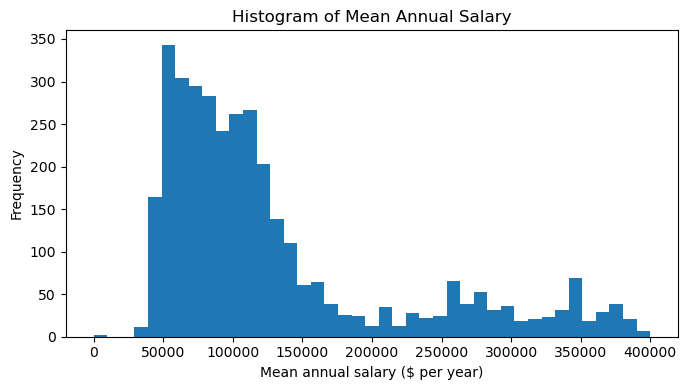

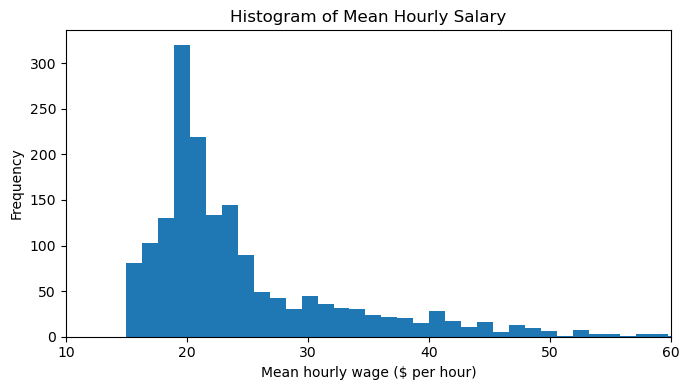

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

annual_mask = refined['pay_frequency'].eq('Per Year')
hourly_mask = refined['pay_frequency'].eq('Per Hour')

annual_vals = pd.to_numeric(refined.loc[annual_mask, 'salary_mean'], errors='coerce').dropna()
hourly_vals = pd.to_numeric(refined.loc[hourly_mask, 'salary_mean'], errors='coerce').dropna()

plt.figure(figsize=(7,4))
plt.hist(annual_vals, bins='fd')   
plt.title('Histogram of Mean Annual Salary')
plt.xlabel('Mean annual salary ($ per year)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.hist(hourly_vals, bins='fd')
plt.xlim(10, 60) 
plt.title('Histogram of Mean Hourly Salary')
plt.xlabel('Mean hourly wage ($ per hour)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# Text processing

In [20]:
import pandas as pd
import nltk 
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
import re

text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']

usa = refined.copy()
usa[text_cols] = usa[text_cols].fillna('').astype(str)

stop_words = set(stopwords.words('english')) | {"amp", "nbsp"}
stop_words.discard("not")

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag: str):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  

def preprocess_text(text: str) -> str:
    text=text.lower()
    text=re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text=re.sub(r'[^\w\s]', '', text)
    tokens = [t for t in word_tokenize(text) if t not in stop_words and t.strip()]
    tagged = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(w, get_wordnet_pos(t)) for w, t in tagged]
    return ' '.join(lemmas)
    
for col in text_cols:
    usa[f'{col}_clean'] = usa[col].apply(preprocess_text)

usa['text_all'] = usa[[f'{c}_clean' for c in text_cols]].agg(' '.join, axis=1)

In [21]:
usa['fraudulent'] = 0

In [22]:
usa_out = usa[[
    'title',
    'company_profile',
    'description',
    'requirements',
    'benefits',
    'location',
    'department',
    'industry',
    'employment_type',
    'salary_min',
    'salary_max',
    'salary_mean',
    'benefits_listed',
    'text_all',
    'fraudulent'
]].copy()

usa_out.to_csv("usajobs_for_validation.csv", index=False)
print("Saved:", usa_out.shape, "to usajobs_for_validation.csv")


Saved: (5201, 15) to usajobs_for_validation.csv
